In [1]:
%cd /mnt/i/Yuki/workspace/exercises/image_processing_100_knock/Gasyori100knock

/mnt/i/Yuki/workspace/exercises/image_processing_100_knock/Gasyori100knock


https://github.com/yoyoyo-yo/Gasyori100knock/tree/master/Question_81_90

# 準備

In [2]:
import os
import re
from collections import Counter
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
thorino_img_path = 'Question_81_90/thorino.jpg'
thorino_img = cv2.imread(thorino_img_path)

## OpenCV は BGR を採用しているので RGB に変換する
BGR を採用している理由は単なる歴史的経緯らしい

In [4]:
thorino_img = thorino_img[:, :, ::-1]

# Utility Function

In [5]:
def get_gray_scale(img):
    return img[:, :, 0] * 0.2126 + img[:, :, 1] * 0.7152 + img[:, :, 2] * 0.0722

In [6]:
def conv(img, kernel):
    K = kernel.shape[0]
    left = K // 2
    right = K - left - 1

    base = img.copy()
    result = np.zeros_like(base).astype(np.float32)
    padded = np.pad(base, (left, right), 'edge')
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = np.sum(padded[i:i+K, j:j+K] * kernel)

    return result

In [7]:
# gaussian_filter = np.array([
#     [1,  4,  6,  4, 1],
#     [4, 16, 24, 16, 4],
#     [6, 24, 36, 24, 6],
#     [4, 16, 24, 16, 4],
#     [1,  4,  6,  4, 1],
# ]) / 256

K = 5
sigma = 1.4

gaussian_filter = np.zeros((K, K))

for i in range(K):
    for j in range(K):
        gaussian_filter[i, j] = np.exp( -((i - K // 2) ** 2 + (j - K // 2) ** 2) / (2 * (sigma ** 2)))

gaussian_filter /= gaussian_filter.sum()

In [8]:
def dilation(img):
    padded = np.pad(img, (1, 1), 'constant')
    filt = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ])
    
    ans = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sum(padded[i:i+3, j:j+3] * filt) >= 255:
                ans[i, j] = 255

    return ans

# 問題

## Q.81. Hessianのコーナー検出

In [9]:
kx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
]).astype(np.float32)

ky = np.array([
    [ 1,  2,  1],
    [ 2,  0,  0],
    [-1, -2, -1],
]).astype(np.float32)

gray = get_gray_scale(thorino_img)

ixx = conv(conv(gray, kx), kx)
ixy = conv(conv(gray, kx), ky)
iyy = conv(conv(gray, ky), ky)

hessian = ixx * iyy - ixy ** 2

In [10]:
maximum = np.zeros_like(hessian)
threshold = np.max(hessian) * 0.1
padded = np.pad(hessian, (1, 1), 'edge')
for i in range(maximum.shape[0]):
    for j in range(maximum.shape[1]):
        if np.max(padded[i:i+3, j:j+3]) == padded[i+1, j+1] and padded[i+1, j+1] >= threshold:
            maximum[i, j] = 255

In [11]:
result = thorino_img.copy()
corner = dilation(dilation(maximum))
result[corner > 0] = [255, 0, 0]

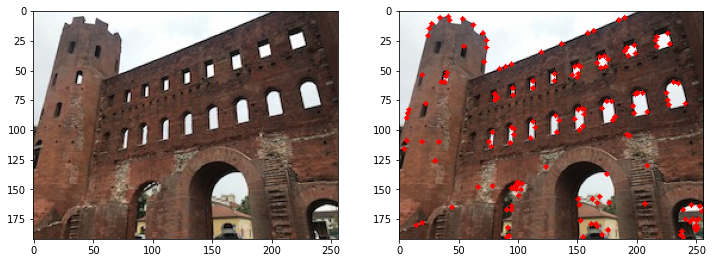

In [12]:
plt.figure(figsize=(12, 24))
plt.subplot(1, 2, 1)
plt.imshow(thorino_img)
plt.subplot(1, 2, 2)
plt.imshow(result, cmap='gray')

## Q.82. Harrisのコーナー検出 (Step.1) Sobel + Gauusian

In [13]:
kx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
]).astype(np.float32)

ky = np.array([
    [ 1,  2,  1],
    [ 2,  0,  0],
    [-1, -2, -1],
]).astype(np.float32)

gk = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1],
]).astype(np.float32) / 16

gray = get_gray_scale(thorino_img)

ixx = conv(conv(conv(gray, kx), kx), gk)
ixy = conv(conv(conv(gray, kx), ky), gk)
iyy = conv(conv(conv(gray, ky), ky), gk)

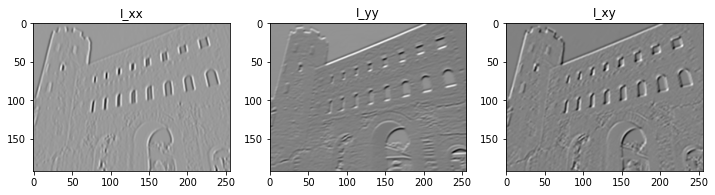

In [14]:
plt.figure(figsize=(12, 36))

plt.subplot(1, 3, 1)
plt.imshow(ixx, cmap='gray')
plt.title('I_xx')

plt.subplot(1, 3, 2)
plt.title('I_yy')
plt.imshow(iyy, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('I_xy')
plt.imshow(ixy, cmap='gray')

## Q.83. Harrisのコーナー検出 (Step.2) コーナー検出

In [15]:
k = 0.04
threshold_ratio = 0.1

R = (ixx * iyy - ixy ** 2) - k * ((ixx + iyy) ** 2)

corner = np.zeros_like(R)
threshold = np.max(R) * threshold_ratio
for i in range(corner.shape[0]):
    for j in range(corner.shape[1]):
        if R[i, j] > threshold:
            corner[i, j] = 255

result = thorino_img.copy()
corner = dilation(corner)
result[corner > 0] = [255, 0, 0]

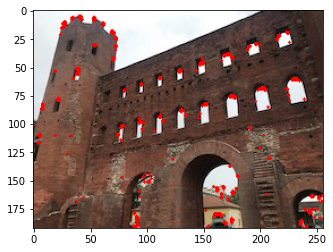

In [16]:
plt.imshow(result)

## Q.84. 簡単な画像認識 (Step.1) 減色化 + ヒストグラム

In [17]:
dir_path = 'Question_81_90/dataset'
train_akahara_to_hist = {}
train_madara_to_hist = {}
test_akahara_to_hist = {}
test_madara_to_hist = {}
for img_name in os.listdir(dir_path):
    img_path = os.path.join(dir_path, img_name)
    img = cv2.imread(img_path)[:, :, ::-1]

    qs = np.zeros_like(img)
    qs[(img >= 0) * (img < 64)] = 1
    qs[(img >= 64) * (img < 128)] = 2
    qs[(img >= 128) * (img < 192)] = 3
    qs[(img >= 192) * (img < 256)] = 4
    qs[:, :, 0] += 8
    qs[:, :, 1] += 4
    
    hists = []
    for i in range(12):
        hists.append(np.sum(qs == i + 1))
    
    hists = np.array(hists)
    
    if img_name.startswith('train_akahara'):
        train_akahara_to_hist[img_name] = hists
    if img_name.startswith('train_madara'):
        train_madara_to_hist[img_name] = hists
    if img_name.startswith('test_akahara'):
        test_akahara_to_hist[img_name] = hists
    if img_name.startswith('test_madara'):
        test_madara_to_hist[img_name] = hists

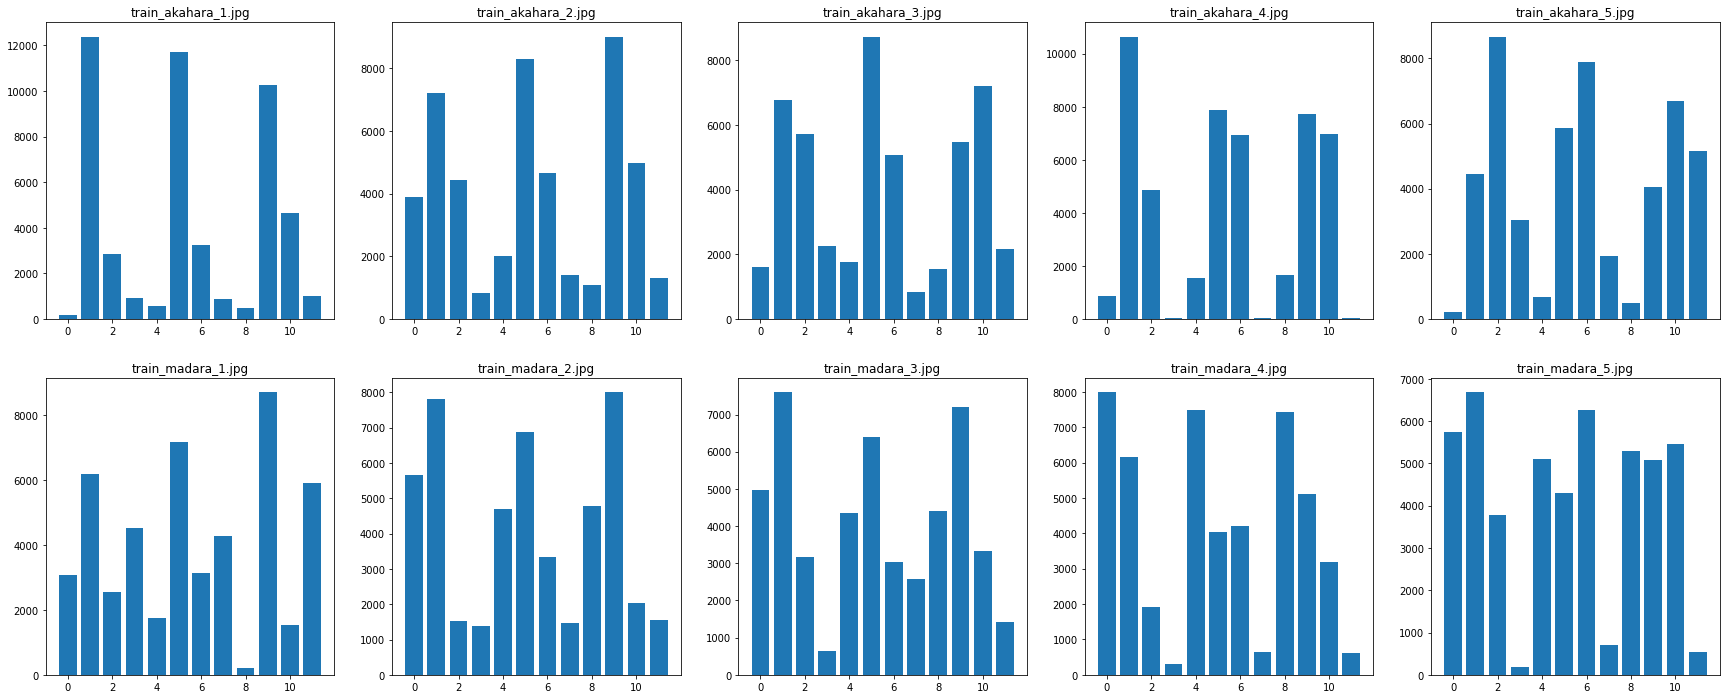

In [18]:
figure = plt.figure(figsize=(30, 12))
for i, key in enumerate(train_akahara_to_hist):
    hist = train_akahara_to_hist[key]
    plt.subplot(2, 5, i + 1)
    plt.bar(np.arange(12), hist)
    plt.title(key)

for i, key in enumerate(train_madara_to_hist):
    hist = train_madara_to_hist[key]
    plt.subplot(2, 5, i + 6)
    plt.bar(np.arange(12), hist)
    plt.title(key)

## Q.85. 簡単な画像認識 (Step.2) クラス判別

In [19]:
def get_label(image_name):
    pattern = re.compile(r'[a-z]+_(?P<label>[a-z]+)_[0-9]+\.jpg')
    return pattern.match(image_name).group('label')

In [20]:
def predict_knn(test_hist, train_dicts, k=1):
    pattern = re.compile(r'[a-z]+_(?P<label>[a-z]+)_[0-9]+\.jpg')
    results = []
    for train_dict in train_dicts: 
        for train_key in train_dict:
            train_hist = train_dict[train_key]
            current_score = np.sum(np.abs(np.array(test_hist) - np.array(train_hist)))
            label = get_label(train_key)
            results.append((train_key, current_score, label))
    
    results = sorted(results, key=lambda x: x[1])[:k]
    images, _, labels = zip(*results)
    label = Counter(labels).most_common()[0][0]

    return images, label

In [21]:
train_dicts = [train_akahara_to_hist, train_madara_to_hist]
for test_key in test_akahara_to_hist:
    test_hist = test_akahara_to_hist[test_key]
    images, pred = predict_knn(test_hist, train_dicts, 1)

    print(f'{test_key} is similar >> {images}  Pred >> {pred}')
for test_key in test_madara_to_hist:
    test_hist = test_madara_to_hist[test_key]
    images, pred = predict_knn(test_hist, train_dicts, 1)

    print(f'{test_key} is similar >> {images}  Pred >> {pred}')

test_akahara_1.jpg is similar >> ('train_akahara_3.jpg',)  Pred >> akahara
test_akahara_2.jpg is similar >> ('train_akahara_1.jpg',)  Pred >> akahara
test_madara_1.jpg is similar >> ('train_madara_2.jpg',)  Pred >> madara
test_madara_2.jpg is similar >> ('train_akahara_2.jpg',)  Pred >> akahara


## Q.86. 簡単な画像認識 (Step.3) 評価(Accuracy)

In [22]:
test_image_count = 0
hit_count = 0

train_dicts = [train_akahara_to_hist, train_madara_to_hist]
for test_key in test_akahara_to_hist:
    test_hist = test_akahara_to_hist[test_key]
    actual = get_label(test_key)
    _, pred = predict_knn(test_hist, train_dicts, 1)
    test_image_count += 1
    if actual == pred:
        hit_count += 1

for test_key in test_madara_to_hist:
    test_hist = test_madara_to_hist[test_key]
    actual = get_label(test_key)
    _, pred = predict_knn(test_hist, train_dicts, 1)
    test_image_count += 1
    if actual == pred:
        hit_count += 1

print(f'Accuracy >> {hit_count / test_image_count} ({hit_count}/{test_image_count})')

Accuracy >> 0.75 (3/4)


## Q.87. 簡単な画像認識 (Step.4) k-NN

In [23]:
test_image_count = 0
hit_count = 0

train_dicts = [train_akahara_to_hist, train_madara_to_hist]
for test_key in test_akahara_to_hist:
    test_hist = test_akahara_to_hist[test_key]
    actual = get_label(test_key)
    images, pred = predict_knn(test_hist, train_dicts, 3)
    test_image_count += 1
    if actual == pred:
        hit_count += 1
    print(f'{test_key} is similar >> {images}  Pred >> {pred}')

for test_key in test_madara_to_hist:
    test_hist = test_madara_to_hist[test_key]
    actual = get_label(test_key)
    images, pred = predict_knn(test_hist, train_dicts, 3)
    test_image_count += 1
    if actual == pred:
        hit_count += 1
    print(f'{test_key} is similar >> {images}  Pred >> {pred}')

print(f'Accuracy >> {hit_count / test_image_count} ({hit_count}/{test_image_count})')

test_akahara_1.jpg is similar >> ('train_akahara_3.jpg', 'train_akahara_2.jpg', 'train_akahara_4.jpg')  Pred >> akahara
test_akahara_2.jpg is similar >> ('train_akahara_1.jpg', 'train_akahara_2.jpg', 'train_akahara_4.jpg')  Pred >> akahara
test_madara_1.jpg is similar >> ('train_madara_2.jpg', 'train_madara_4.jpg', 'train_madara_3.jpg')  Pred >> madara
test_madara_2.jpg is similar >> ('train_akahara_2.jpg', 'train_madara_3.jpg', 'train_madara_2.jpg')  Pred >> madara
Accuracy >> 1.0 (4/4)


## Q.88. K-means (Step.1) 重心作成

In [24]:
dir_path = 'Question_81_90/dataset'
test_image_names = []
features = []
for img_name in os.listdir(dir_path):
    if not img_name.startswith('test'):
        continue
    test_image_names.append(img_name)

    img_path = os.path.join(dir_path, img_name)
    img = cv2.imread(img_path)[:, :, ::-1]

    qs = np.zeros_like(img)
    qs[(img >= 0) * (img < 64)] = 1
    qs[(img >= 64) * (img < 128)] = 2
    qs[(img >= 128) * (img < 192)] = 3
    qs[(img >= 192) * (img < 256)] = 4
    qs[:, :, 0] += 8
    qs[:, :, 1] += 4
    
    hists = []
    for i in range(12):
        hists.append(np.sum(qs == i + 1))
    features.append(hists)

features = np.array(features)

In [25]:
np.random.seed(1)
labels = np.array([1 if np.random.rand() < 0.5 else 0 for _ in range(len(test_image_names))])
means = np.zeros((2, features.shape[1]))

for label in range(2):
    if np.any(labels == label):
        means[label] = np.mean(features[labels == label], axis=0)
        
print(means)

[[  109.         10783.          3239.          2253.
    630.         12289.          2206.          1259.
    481.         11197.          4160.           546.        ]
 [ 3802.33333333  7291.          3336.33333333  1954.33333333
   3754.33333333  7088.66666667  3627.66666667  1913.33333333
   3608.33333333  6785.33333333  3806.66666667  2183.66666667]]


## Q.89. K-means (Step.2) クラスタリング

In [26]:
dir_path = 'Question_81_90/dataset'
test_image_names = []
features = []
for img_name in os.listdir(dir_path):
    if not img_name.startswith('test'):
        continue
    test_image_names.append(img_name)

    img_path = os.path.join(dir_path, img_name)
    img = cv2.imread(img_path)[:, :, ::-1]

    qs = np.zeros_like(img)
    qs[(img >= 0) * (img < 64)] = 1
    qs[(img >= 64) * (img < 128)] = 2
    qs[(img >= 128) * (img < 192)] = 3
    qs[(img >= 192) * (img < 256)] = 4
    qs[:, :, 0] += 8
    qs[:, :, 1] += 4
    
    hists = []
    for i in range(12):
        hists.append(np.sum(qs == i + 1))
    features.append(hists)

features = np.array(features)

In [27]:
np.random.seed(1)
labels = np.array([1 if np.random.rand() < 0.5 else 0 for _ in range(len(test_image_names))])
means = np.zeros((2, features.shape[1]))

prev_labels = None
while prev_labels is None or not np.all(labels == prev_labels):
    for label in range(2):
        if np.any(labels == label):
            means[label] = np.mean(features[labels == label], axis=0)

    dists = np.sum((np.expand_dims(means, 1) - features) ** 2, axis=2)
    prev_labels = labels.copy()
    labels = np.argmin(dists, axis=0)

In [28]:
for test_image_name, label in zip(test_image_names, labels):
    print(f'{test_image_name}  Pred: {label}')

test_akahara_1.jpg  Pred: 1
test_akahara_2.jpg  Pred: 0
test_madara_1.jpg  Pred: 1
test_madara_2.jpg  Pred: 1


## Q.90. K-means (Step.3) 初期ラベルの変更

In [29]:
dir_path = 'Question_81_90/dataset'
train_image_names = []
features = []
for img_name in os.listdir(dir_path):
    if not img_name.startswith('train'):
        continue
    train_image_names.append(img_name)

    img_path = os.path.join(dir_path, img_name)
    img = cv2.imread(img_path)[:, :, ::-1]

    qs = np.zeros_like(img)
    qs[(img >= 0) * (img < 64)] = 1
    qs[(img >= 64) * (img < 128)] = 2
    qs[(img >= 128) * (img < 192)] = 3
    qs[(img >= 192) * (img < 256)] = 4
    qs[:, :, 0] += 8
    qs[:, :, 1] += 4
    
    hists = []
    for i in range(12):
        hists.append(np.sum(qs == i + 1))
    features.append(hists)

features = np.array(features)

In [30]:
count = 1
while True:
    print(f'Try {count}')
    count += 1
    labels = np.array([1 if np.random.rand() < 0.5 else 0 for _ in range(len(train_image_names))])
    means = np.zeros((2, features.shape[1]))

    prev_labels = None
    while prev_labels is None or not np.all(labels == prev_labels):
        for label in range(2):
            if np.any(labels == label):
                means[label] = np.mean(features[labels == label], axis=0)

        dists = np.sum((np.expand_dims(means, 1) - features) ** 2, axis=2)
        prev_labels = labels.copy()
        labels = np.argmin(dists, axis=0)

    actual_to_predict = {}
    for train_image_name, label in zip(train_image_names, labels):
        actual_label = get_label(train_image_name)
        if actual_label not in actual_to_predict:
            actual_to_predict[actual_label] = set()
        actual_to_predict[actual_label].add(label)

    for actual in actual_to_predict:
        if len(actual_to_predict[actual]) >= 2:
            break
    else:
        break
    continue

Try 1


In [31]:
for train_image_name, label in zip(train_image_names, labels):
    print(f'{train_image_name}  Pred: {label}')

train_akahara_1.jpg  Pred: 1
train_akahara_2.jpg  Pred: 1
train_akahara_3.jpg  Pred: 1
train_akahara_4.jpg  Pred: 1
train_akahara_5.jpg  Pred: 1
train_madara_1.jpg  Pred: 0
train_madara_2.jpg  Pred: 0
train_madara_3.jpg  Pred: 0
train_madara_4.jpg  Pred: 0
train_madara_5.jpg  Pred: 0
